# C1 W1 Group 8

In [22]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

from src.data import GT_QSD1_W1_LIST
from src.paths import BBDD_PATH, QSD1_W1_PATH

## Task 1 - Create Museum and query image descriptors (BBDD & QSD1)

In [23]:
def get_grayscale_histogram_descriptor(image: Image, bins: int = 256) -> np.array:
    histogram, _ = np.histogram(image.convert('L'), bins=bins, range=(0, bins-1))
    return histogram

In [ ]:
def get_concatenated_hsv_histogram_descriptor(image: Image, bins: int = 256) -> np.array:
    hsv_histograms = []
    for hsv_channel in np.transpose(image.convert("HSV"), (2, 0, 1)):
        histogram, _ = np.histogram(hsv_channel, bins=bins, range=(0, bins-1))
        hsv_histograms.append(histogram)
    hsv_histograms = np.concatenate(hsv_histograms)
    return hsv_histograms

In [34]:
def get_concatenated_hsv_histogram_descriptor(image: Image, bins: int = 256) -> np.array:
    hsv_histograms = []
    for hsv_channel in np.transpose(image.convert("HSV"), (2, 0, 1)):
        histogram, _ = np.histogram(hsv_channel, bins=bins, range=(0, bins-1))
        hsv_histograms.append(histogram)
    hsv_histograms = np.concatenate(hsv_histograms)
    return hsv_histograms

In [35]:
get_descriptors_func = get_concatenated_hsv_histogram_descriptor

In [36]:
# Database image descriptors

database_image_descriptors = []
for database_image_path in BBDD_PATH.glob("*.jpg"):
    database_image_PIL = Image.open(database_image_path)
    descriptors = get_descriptors_func(database_image_PIL)
    database_image_descriptors.append(descriptors)
database_image_descriptors = np.array(database_image_descriptors)

In [38]:
# Query image descriptors

query_image_descriptors = []
for query_image_path in QSD1_W1_PATH.glob("*.jpg"):
    query_image_PIL = Image.open(query_image_path)
    descriptors = get_descriptors_func(query_image_PIL)
    query_image_descriptors.append(descriptors)
query_image_descriptors = np.array(query_image_descriptors)

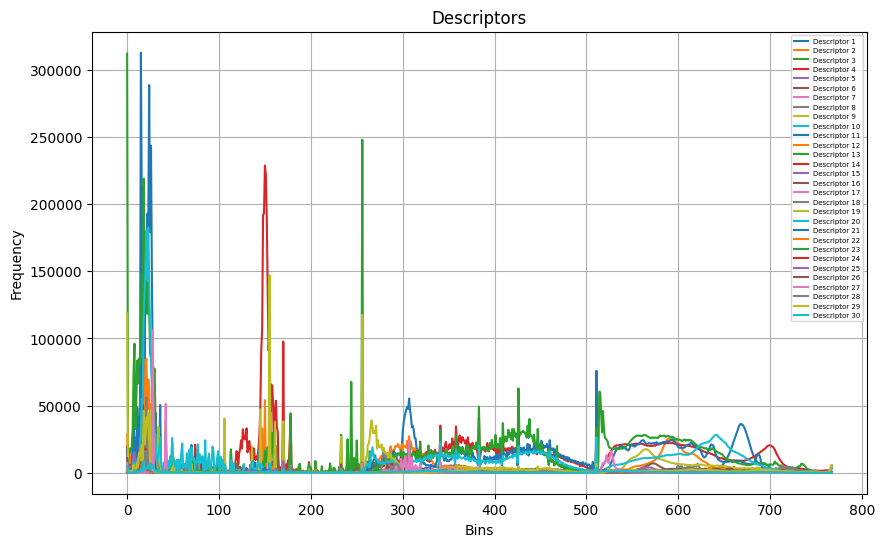

In [39]:
# Create a plot for each histogram in the array
bins = np.arange(query_image_descriptors.shape[1])
plt.figure(figsize=(10, 6))
for i, hist in enumerate(query_image_descriptors):
    plt.plot(bins, hist, label=f'Descriptor {i+1}')

# Labeling the plot
plt.title('Descriptors')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.legend(fontsize=5)
plt.grid(True)

# Show the plot
plt.show()

## Task 2 - Implement / compute similarity measures to compare images

In [46]:
def compute_mse(arr1: np.array, arr2: np.array) -> np.array:
    # Compute pairwise squared differences
    differences = arr1[:, np.newaxis, :] - arr2[np.newaxis, :, :]
    squared_diff = np.square(differences)
    
    # Mean over the last dimension (K) to get MSE between each pair of points
    return squared_diff.mean(axis=2)

In [44]:
def compute_mse(arr1: np.array, arr2: np.array) -> np.array:
    # Step 1: Compute the squared sum of A and B
    A_squared = np.sum(arr1 ** 2, axis=1).reshape(-1, 1)  # Shape (N, 1)
    B_squared = np.sum(arr2 ** 2, axis=1).reshape(1, -1)  # Shape (1, M)

    # Step 2: Compute the dot product between A and B (A * B^T)
    AB_dot = np.dot(arr1, arr2.T)  # Shape (N, M)

    # Step 3: Calculate the distance matrix
    dists_squared = A_squared + B_squared - 2 * AB_dot
    return np.sqrt(dists_squared)  # Element-wise square root

In [49]:
query_distances = compute_mse(query_image_descriptors, database_image_descriptors)
query_distances.shape

(30, 287)

## Task 3 - Implement retrieval system (retrieve top K results)

In [53]:
def get_topk_distances(distances: np.array, k: int = 1):
    # Get the indices of the top k minimum values for each row
    indices = np.argsort(distances, axis=1)[:, :k]
    
    # Gather the top k scores using the indices
    scores = np.take_along_axis(distances, indices, axis=1)
    
    return indices, scores

In [54]:
indices, scores = get_topk_distances(query_distances)

In [58]:
from sklearn.metrics import recall_score

recall_score(indices, GT_QSD1_W1_LIST, average="macro")

C:\Users\gerar\Documents\CVM\C1\code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


np.float64(0.028409090909090908)

## Task 4 - Create predictions for blind challenge (QST1)